In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
%load_ext sql
%sql postgresql://localhost/bankcalls
%config SqlMagic.autopandas =  True

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [45]:
# sklearn stuff goes here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics

# Load the columns that looked most promising in our EDA

In [31]:
%%sql  df << 
/*--  initial predictors looked interesting in the EDA notebook  --*/
SELECT 
/*-- categorical predictors --*/
       job, 
       contact, 
       month, 
       poutcome, 
        
/*-- integer predictors     --*/
       previous, 
        
/*-- float predictors       --*/
       cons_price_idx, 
       cons_conf_idx, 
       euribor3m,
    
/*-- target column          --*/
       success
FROM  
       bank_addl;

 * postgresql://localhost/bankcalls
41188 rows affected.
Returning data to local variable df


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 9 columns):
job               41188 non-null object
contact           41188 non-null object
month             41188 non-null object
poutcome          41188 non-null object
previous          41188 non-null int64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
success           41188 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 2.8+ MB


## We can save some memory by hashing all the categorical predictors


In [33]:
df['job']      = df[     'job'].astype('category')
df['contact']  = df[ 'contact'].astype('category')
df['month']    = df[   'month'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')

### For the target column, change explicitly to 0 or 1

In [34]:
df['success'] =  df['success'].replace({'yes': 1, 'no': 0})

In [35]:
df.success.value_counts()

0    36548
1     4640
Name: success, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 9 columns):
job               41188 non-null category
contact           41188 non-null category
month             41188 non-null category
poutcome          41188 non-null category
previous          41188 non-null int64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
success           41188 non-null int64
dtypes: category(4), float64(3), int64(2)
memory usage: 1.7 MB


# Split into train and test data

In [37]:
y = df['success']
X = df.drop(columns='success')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=33)

# Build a model 

## Preprocessing the inputs

In [39]:
numerical = [ 'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m' ]
categorical = [ 'job', 'contact', 'month', 'poutcome' ]

In [40]:
standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train[numerical])
X_test_scaled  = standard.transform(X_test[numerical])

/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jlc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
X_train_dummies = pd.get_dummies(X_train[categorical], drop_first=True)
X_test_dummies =  pd.get_dummies(X_test[categorical], drop_first=True)

In [42]:
X_train_onehot = X_train_dummies.values
X_test_onehot =  X_test_dummies.values

In [43]:
X_train_prepped = np.concatenate([X_train_scaled, X_train_onehot], axis = 1)
X_test_prepped  = np.concatenate([X_test_scaled, X_test_onehot], axis = 1)

coef_names = numerical + list(X_train_dummies.columns)

# Run a model

In [95]:
lr = LogisticRegressionCV(solver='lbfgs', cv=6, random_state=33)
lr.fit(X_train_prepped, y_train)
lr.score(X_train_prepped, y_train)

0.8997572078907435

In [97]:
y_predict = lr.predict(X_test_prepped)
lr.score(X_test_prepped, y_test)

0.8977907259043457

In [98]:
lr.intercept_

array([-2.53451442])

In [99]:
pd.DataFrame(index=coef_names, data=lr.coef_.reshape(-1,1)).round(decimals=5)

,0
previous,0.02554
cons_price_idx,0.30697
cons_conf_idx,0.22015
euribor3m,-0.98824
job_blue-collar,-0.25788
job_entrepreneur,-0.04574
job_housemaid,-0.10499
job_management,-0.03427
job_retired,0.24791
job_self-employed,-0.15636


### QUESTION - What do I do with the probabilities?

In [100]:
probs = pd.DataFrame(lr.predict_proba(X_test_prepped))
probs.describe()

,0,1
count,8238.000000,8238.000000
mean,0.886246,0.113754
std,0.145919,0.145919
min,0.094496,0.023621
25%,0.895209,0.044126
50%,0.942879,0.057121
75%,0.955874,0.104791
max,0.976379,0.905504


# Analyze metrics 

Due to the unbalanced classes, just predicting zeroes should be a very good prediction, so that will be the 
model to beat for the minimum viable project.

## Accuracy

In [101]:
metrics.accuracy_score(y_predict, y_test)

0.8977907259043457

In [102]:
just_guess_zeroes = np.zeros(len(y_test))

In [103]:
metrics.accuracy_score(just_guess_zeroes, y_test)

0.8852876911871813

## Confusion matrix

In [104]:
cm = metrics.confusion_matrix(y_test, y_predict)
pd.DataFrame(index=['actual_neg', 'actual_pos'], columns=['predict_neg', 'predict_pos'], data=cm)

,predict_neg,predict_pos
actual_neg,7178,115
actual_pos,727,218


In [105]:
cm = metrics.confusion_matrix(y_test, just_guess_zeroes)
pd.DataFrame(index=['actual_neg', 'actual_pos'], columns=['zero_neg', 'zero_pos'], data=cm)

,zero_neg,zero_pos
actual_neg,7293,0
actual_pos,945,0


## Classification Report

__micro__:  Calculate metrics globally by counting the total true positives, false negatives and false positives.

__macro__:  Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

__weighted__:  Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.


In [106]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7293
           1       0.65      0.23      0.34       945

   micro avg       0.90      0.90      0.90      8238
   macro avg       0.78      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238



__precision__:  What percent of what the model assigned label (0,1) is correctly labeled? 
- The just_guess_zeroes model is 89% precision for the 0 case. 89% of what's labeled 0 is actually a zero. 
Precision is undefined for the success case as there are no 1 predictions.

__recall__: What percent of the (0,1) population is correctly labeled? 
- The just_guess_zeroes model has 100% recall for the 0 label - all the 0 population is correctly labeled zero. 
It has 0% recall for the 1 label - all the 1 population in the test_y set is incorrectly labeled.

In [108]:
print(metrics.classification_report(y_test, just_guess_zeroes))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7293
           1       0.00      0.00      0.00       945

   micro avg       0.89      0.89      0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.78      0.89      0.83      8238



## ROC Curves

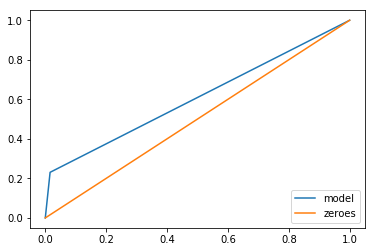

In [117]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
plt.plot(fpr, tpr, label='model')
fpr0, tpr0, thresholds = metrics.roc_curve(y_test, just_guess_zeroes)
plt.plot(fpr0, tpr0,label='zeroes')
plt.legend(loc=4)

In [120]:
# And the area under the curve for the model and 
# the all-zeroes case

roc_auc = metrics.auc(fpr, tpr)
print("Model ROC AUC", roc_auc)

roc_auc = metrics.auc(fpr0, tpr0)
print("Zeroes ROC AUC", roc_auc)

Model ROC AUC 0.6074596427537604
Zeroes ROC AUC 0.5
